# Week5
- 用L表示神经网络的总层数, $s_i$表示第i层的单元个数(不包括bias单元)
- Cost Function. 类似于Logistic regression的代价函数
$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K[y_k^{(i)}log((h_{\Theta}(x^{(i)}))_k)+(1-y_k^{(i)})log(1-(h_{\Theta}(x^{(i)}))_k)]+\frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}(\Theta_{j,i}^{(l)})^2$$
m为样本数, k为类别数量, L为总层数, $s_l$为第l层unit个数(不包括bias)
- 最小化代价函数 反向传播即链式求导  
  1. $\alpha^{(i)}$为第i层网络每个单元的输出(包括bias) 求出所有层的输出
  2. $\delta^{(i)}$为第i层网络每个单元的误差? 先求出最后一层 $\delta^{(L)}=\alpha^{(L)}-y^{(t)}$
  3. 计算$\delta^{(L-1)},\delta^{(L-2)}...\delta^{(2)}$  使用$\delta^{(l)} = ((\Theta^{(l)})^T\delta^{(l+1)}).*\alpha^{(l)}.*(1-\alpha^{(l)})$
  4. $\Delta^{(l)}=\Delta^{(l)}+\delta^{(l+1)}(\alpha^{(l)})^T$
  5. 对所有的样例重复以上四个步骤之后, 计算梯度为:  
  $$D_{i,j}^{(l)} = \frac{1}{m}(\Delta_{i,j}^{(l)}+\lambda\Theta_{i,j}^{(l)})　if　j\neq0$$
  $$D_{i,j}^{(l)} = \frac{1}{m}\Delta_{i,j}^{(l)}　if　j=0$$
- Unrolling Parameters
当使用scipy.optimize.minimize函数时, 需要自己定义Cost和Gradient函数, 要求theta为向量, 因此定义这两个函数时将神经网络多层的参数unrolling成一个向量, Gradient返回的向量也是这样生成.
- Gradient Checking
该部分为检验你定义的Cost函数和Gradient函数是否正确. 对于参数$\Theta$, 分别对其中每个参数求$\frac{J(\Theta_i+\epsilon)-J(\Theta_i-\epsilon)}{2\epsilon}$, 得到一个向量. 将该向量与Gradient($\Theta$)比较是否近似. 通常取$\epsilon=10^{-4}$
- 随机初始化参数
若在神经网络中把所有参数初始化为0, 则所有节点将用相同的值更新, 此时无法正常工作. 因为将参数随机初始化.
- 多个局部最小值
神经网络并不是一个凸函数, 因此我们找到的最优参数不一定就是全局最优值, 但通常找到的局部最小值的Cost已经足够小, 因此我们可以使用该局部最优值.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import scipy.optimize as op

# 到可视化数据都与ex3相同
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10
# 读入数据
data = sio.loadmat('data/ex4data1.mat')
X = data['X']
y = data['y']

In [2]:
print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


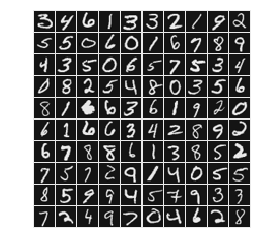

In [3]:
# 随机显示100个数据
def displayData(X, example_width=10):
    pad = 1    # 两个图片之间的边界
    digit_width = 20   # 每个手写数字图片为20*20
    n = X.shape[0]
    example_height = math.ceil(n/example_width)
    image = np.ones((pad+example_height*(digit_width+pad), pad+example_width*(digit_width+pad)))  #用来显示图片的数组
    for i in range(n):
        rows = i // example_width # 第几排数字
        cols = i - rows*example_width # 第几列数字
        image[pad+rows*(pad+digit_width):pad+rows*(pad+digit_width)+digit_width, pad+cols*(pad+digit_width):pad+cols*(pad+digit_width)+digit_width] \
                = X[i].reshape(digit_width, digit_width, order="F")   #order="F"表示按照列reshape, 这是因为matlab中是这样的
    plt.imshow(image,cmap='gray')   #显示该矩阵的灰度图像
    plt.axis('off')
    plt.show()
random_order = np.arange(X.shape[0])
np.random.shuffle(random_order)
displayData(X[random_order[:100]])

In [4]:
# 载入参数
Theta = sio.loadmat('data/ex4weights.mat')
Theta1 = Theta['Theta1']
Theta2 = Theta['Theta2']
print(Theta1.shape)  # 第一层参数
print(Theta2.shape)  # 第二层参数
# 将网络参数合并为单个向量
theta = np.r_[Theta1.reshape(np.size(Theta1)), Theta2.reshape(np.size(Theta2))]

(25, 401)
(10, 26)


In [5]:
# 定义Cost函数
sigmoid = lambda x : 1/(1+np.exp(-x))
def costFunctionNN(theta, X, y, ld):
    # theta is (n,), X m*n, y m*1
    m, n = X.shape
    K = 10

    def constructY(x):
        res = np.zeros(K)
        res[x-1] = 1
        return res

    Y = np.apply_along_axis(constructY, 1, y)  # Y为m*n, 其中每行为1的列索引为对应标签

    # 将theta转为theta1(hidden_layer_size*(input_layer_size+1))  theta2(output_layer_size*(hidden_layer_size+1))
    # theta1为input_layer到hidden_layer的参数, theta2为hidden_layer到output_layer的参数
    theta1 = theta[:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
    theta2 = theta[hidden_layer_size * (input_layer_size + 1):].reshape(output_layer_size, hidden_layer_size + 1)

    h = np.c_[np.ones(m), X]
    h = sigmoid(h.dot(theta1.T))
    h = np.c_[np.ones(m), h]
    h = sigmoid(h.dot(theta2.T))
    return (-Y * np.log(h) - (1.0 - Y) * np.log(1.0 - h)).sum() / m + ld / (2.0 * m) * (
                (theta1[:, 1:] ** 2).sum() + (theta2[:, 1:] ** 2).sum())
    
# 当lambda为0时, 输出0.287629
print(costFunctionNN(theta, X, y, 0))
# 当lambda为0时, 输出0.383770
print(costFunctionNN(theta, X, y, 1))

0.2876291651613189
0.38376985909092365


In [6]:
# Sigmoid gradient. g'(z) = g(z)(1-g(z))
sigmoid_gradient = lambda x:sigmoid(x)*(1.0-sigmoid(x))

# test
print(sigmoid_gradient(np.array([-1, -0.5, 0, 0.5, 1])))

[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [7]:
# random initialization
def getRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    num = hidden_layer_size * (input_layer_size+1) + output_layer_size * (hidden_layer_size+1)
    return np.random.rand(num) * 2 * epsilon_init - epsilon_init

In [8]:
# backpropagation
def gradientNN(theta, X, y, ld):
    # theta is (n,), X m*n, y m*1
    m, n = X.shape
    K = 10

    def constructY(x):
        res = np.zeros(K)
        res[x-1] = 1
        return res

    Y = np.apply_along_axis(constructY, 1, y)  # Y为m*n, 其中每行为1的列索引为对应标签
    # 将theta转为theta1(hidden_layer_size*(input_layer_size+1))  theta2(output_layer_size*(hidden_layer_size+1))
    # theta1为input_layer到hidden_layer的参数, theta2为hidden_layer到output_layer的参数
    theta0 = theta[:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
    theta1 = theta[hidden_layer_size * (input_layer_size + 1):].reshape(output_layer_size, hidden_layer_size + 1)

    # forward pass
    a0 = np.c_[np.ones(m), X]  # m*401
    a1 = np.c_[np.ones(m), sigmoid(a0.dot(theta0.T))]  # m*26
    a2 = sigmoid(a1.dot(theta1.T))  # m*10

    # back pass
    err2 = a2 - Y
    err1 = np.dot(err2, theta1) * a1 * (1.0 - a1)
    err1 = err1[:, 1:]
    # compute Delta
    Delta1 = 1.0 / m * np.array([np.dot(a[:, None], b[None, :]) for a, b in zip(err2, a1)]).sum(axis=0)  # 10*26
    Delta0 = 1.0 / m * np.array([np.dot(a[:, None], b[None, :]) for a, b in zip(err1, a0)]).sum(axis=0)  # 25, 401
    Delta1[:, 1:] += ld / m * theta1[:, 1:]
    Delta0[:, 1:] += ld / m * theta0[:, 1:]
    return np.r_[Delta0.reshape(np.size(Theta1)), Delta1.reshape(np.size(Theta2))]
    

In [9]:
# Gradient checking
def gradient_checking(theta, X, y, ld):
    epsilon = 1e-4
    n = theta.size
    actual_grad = gradientNN(theta, X, y, ld)
    print(actual_grad[[8405, 3247, 5644, 96]])
    for i in range(10):
        x = int(np.random.rand()*len(theta))
        epsvec = np.zeros(len(theta))
        epsvec[x] = epsilon
        cost_high = costFunctionNN(theta+epsvec, X, y, ld)
        cost_low = costFunctionNN(theta-epsvec, X, y, ld)
        mygrad = (cost_high - cost_low) / (2.0*epsilon)
        print('Element: {} Evaluate is = {}, Actual is = {}'.format(x, mygrad, actual_grad[x]))


In [10]:
gradient_checking(theta, X, y, 1)

[-9.35677161e-06 -2.29375110e-08 -9.94849297e-06  1.10070173e-04]
Element: 4157 Evaluate is = -9.080223656310338e-05, Actual is = -9.080223645199835e-05
Element: 7480 Evaluate is = -1.3991952596548174e-05, Actual is = -1.399195253429601e-05
Element: 9199 Evaluate is = 2.0300483516422219e-07, Actual is = 2.0300460913719794e-07
Element: 6714 Evaluate is = 1.272592392576044e-05, Actual is = 1.2725923837352054e-05
Element: 9870 Evaluate is = -0.00027193782947687595, Actual is = -0.0002719378324646512
Element: 9648 Evaluate is = 1.9856782884630775e-07, Actual is = 1.9856754561557055e-07
Element: 314 Evaluate is = 5.335273639550664e-05, Actual is = 5.3352735707358594e-05
Element: 3542 Evaluate is = -8.087713582183298e-05, Actual is = -8.087713585398687e-05
Element: 1355 Evaluate is = -0.0002031995913198692, Actual is = -0.00020319959068086868
Element: 359 Evaluate is = -2.659058806475656e-06, Actual is = -2.659058937931872e-06


In [11]:
def trainNN(X, y, lb, maxiter=100):
    res = op.minimize(fun=costFunctionNN, x0=getRandThetas(), args=(X, y, 0), method='TNC', jac=gradientNN, options={
                'maxiter': maxiter
            })
    return res['x']

In [12]:
def predict(theta, X):
    # theta is (n,), X m*n, y m*1
    m, n = X.shape
    K = 10
    
    # 将theta转为theta1(hidden_layer_size*(input_layer_size+1))  theta2(output_layer_size*(hidden_layer_size+1))
    # theta1为input_layer到hidden_layer的参数, theta2为hidden_layer到output_layer的参数
    theta1 = theta[:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
    theta2 = theta[hidden_layer_size * (input_layer_size + 1):].reshape(output_layer_size, hidden_layer_size + 1)
    h = np.c_[np.ones(m), X]
    h = sigmoid(h.dot(theta1.T))
    h = np.c_[np.ones(m), h]
    h = sigmoid(h.dot(theta2.T))
    return h.argmax(axis=1)+1

def cal_accuracy(theta, X, y):
    return (predict(theta, X) == y.flatten()).sum() / len(y)

In [15]:
# lambda 为0, maxiter 为100
print('当lambda为0时: ')
print(cal_accuracy(trainNN(X, y, 0), X, y))

# lambda 为10, maxiter 为100
print('当lambda为10时: ')
print(cal_accuracy(trainNN(X, y, 10), X, y))

当lambda为0时: 
0.9142
当lambda为10时: 
0.863


In [ ]:
# 隐藏层可视化
